# FIRST NOTEBOOK TO TEST MOST IMPORTANT FEATURES

## SETTING LOGGING LEVEL TO CRITICAL

In [ ]:
import logging
import mne

# Get the MNE logger
mne_logger = logging.getLogger('mne')

# Set the MNE logger level to CRITICAL
mne_logger.setLevel(logging.CRITICAL)

# Now MNE will only log critical messages


# Generate image function

## Azimuthal projection and image resolution

In [ ]:
import numpy as np
AZ_PROJ_VALUE = np.array([
    [-0.0309026, 0.11458518],
    [0.02840949, 0.11534631],
    [-0.05180905, 0.0866879],
    [0.05027427, 0.08743839],
    [-0.07187663, 0.07310353],
    [0.07143526, 0.07450512],
    [-0.08598209, 0.01487164],
    [0.08326136, 0.01525818],
    [-0.06714873, 0.02335823],
    [0.06532887, 0.0235731],
    [-0.07445797, -0.04212316],
    [0.07103246, -0.04225998],
    [-0.05503824, -0.0442103],
    [0.05363601, -0.04433453],
    [-0.03157357, -0.08056835],
    [0.02768309, -0.08048884],
    [-0.00122928, 0.09327445],
    [-0.00137414, 0.02761709],
    [-0.00170945, -0.04521299]
])
IMG_RESOLUTION = 64

## EEG signal to 2D azimuthal images function

In [ ]:
from sklearn.preprocessing import scale
from scipy.interpolate import griddata
def augment_EEG(features, std_mult, pca=False, n_components=2):
    # Placeholder for EEG data augmentation logic.
    pass

def gen_images(features,locs=AZ_PROJ_VALUE, n_gridpoints = IMG_RESOLUTION, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]  # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes: nElectrodes * (c + 1)])

    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints * 1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints * 1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y], [max_x, min_y], [max_x, max_y]]), axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                               method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i + 1, nSamples), end='\r')
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)  # swap axes to have [samples, colors, W, H]



## Data strategy for models LSTM-CNN1 & LSTM-CNN2

## Helpers function

In [ ]:
def classify_attribute(value, classification_dict):
    """
    Classifies a value based on ranges provided in a dictionary.

    Parameters:
    - value: The attribute value to classify.
    - classification_dict: A dictionary where keys are class labels and values are tuples representing the range (inclusive).

    Returns:
    - A class label as a string.
    """
    for label, (min_val, max_val) in classification_dict.items():
        if min_val <= value <= max_val:
            return label
    return 'Undefined'  # If value doesn't fit any provided range


In [ ]:
def map_name_to_attribute(df, name_col, attr_col):
    """
    Takes a DataFrame and returns a dictionary mapping names to their corresponding attribute values.

    Parameters:
    - df: DataFrame containing at least the columns specified by `name_col` and `attr_col`.
    - name_col: The name of the column containing the names.
    - attr_col: The name of the column containing the attribute to map.

    Returns:
    - A dictionary with names as keys and attribute values as values.
    """
    # Extract the relevant columns and drop any rows with missing values
    relevant_df = df[[name_col, attr_col]].dropna()
    # Convert to dictionary
    attribute_dict = dict(zip(relevant_df[name_col], relevant_df[attr_col]))

    return attribute_dict


## Create mapping using the above function

### Load data frame

In [ ]:
import pandas as pd
mapping_file = "labels.xlsx"
df = pd.read_excel(mapping_file, skiprows=1)

In [ ]:
df

,ФИО,Д.р.,пол,курс/работа,заполнения,уровень невротизации,feelings,daydreaming,analytic,factor 1 (Difficulty Identifying Feelings),...,ЭмоцИстощ,Деперсонализация,Редукция Личн.Достиж,burnout_MBI,Индекс СХУ,СФД,С0СКД,НЭАС,СМИССО,Уровень депрессии
0,azo,1990-06-29,М,"1 курс, пси, КНУ",2010-03-19,33.0,43.0,9.0,12.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ale,1992-07-13,Ж,"1 курс, пси, КНУ",2010-03-19,24.0,32.0,10.0,12.0,25.0,...,21.0,9.0,34.0,64.0,25.0,6.0,9.0,7.0,3.0,NaN
2,andri,1990-07-08,Ж,"3 курс, микробиол., БФ, КНУ",2011-05-21,27.0,40.0,12.0,21.0,30.0,...,38.0,16.0,26.0,80.0,46.0,17.0,14.0,7.0,8.0,29.0
3,andru,1993-01-17,Ж,"2 курс, биофак, КНУ",2011-05-29,16.0,36.0,10.0,21.0,27.0,...,20.0,12.0,14.0,46.0,16.0,4.0,3.0,6.0,3.0,44.0
4,bas,1994-07-31,Ж,"1 курс, пси, КНУ",2012-03-19,17.0,42.0,11.0,12.0,36.0,...,20.0,14.0,30.0,64.0,25.0,10.0,5.0,7.0,3.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,yur,1993-05-24,Ж,"2 курс, Ин-т журн., КНУ",2011-11-14,20.0,19.0,9.0,15.0,15.0,...,23.0,11.0,28.0,62.0,20.0,13.0,1.0,2.0,4.0,27.0
253,yurc,1995-03-19,Ж,"1 курс, пси, КНУ",2012-11-21,27.0,NaN,NaN,NaN,NaN,...,28.0,15.0,32.0,75.0,34.0,11.0,10.0,10.0,3.0,29.0
254,yak,1988-07-04,М,"4 курс, зоолог, КНУ, инженер",2010-04-19,18.0,33.0,11.0,15.0,22.0,...,37.0,22.0,30.0,89.0,38.0,7.0,15.0,9.0,7.0,NaN
255,yar,1994-11-26,Ж,"1 курс, пси, КНУ",2012-11-02,16.0,41.0,9.0,16.0,33.0,...,32.0,14.0,25.0,71.0,41.0,10.0,14.0,10.0,7.0,18.0


In [ ]:
col_interest = ['ФИО','Напряжение','Резистенция','Истощение','burnout_Boiko'] # add more columns if you want
df = df[col_interest]
df.head()

,ФИО,Напряжение,Резистенция,Истощение,burnout_Boiko
0,azo,36.0,66.0,33.0,135.0
1,ale,17.0,30.0,17.0,64.0
2,andri,60.0,62.0,87.0,209.0
3,andru,19.0,67.0,40.0,126.0
4,bas,16.0,53.0,34.0,103.0


### Handling missing values

In [ ]:
print(f"Shape before dropping missing values: {df.shape}")
df = df.dropna()

Shape before dropping missing values: (257, 5)


In [ ]:
print(f"Shape after dropping missing values: {df.shape}")

Shape after dropping missing values: (254, 5)


In [ ]:
df.rename(columns={'ФИО': 'name', 'Напряжение': 'tension', 'Резистенция' : 'resistance', 'Истощение' : 'exhaustion', 'burnout_Boiko': 'Boiko'}, inplace=True)

In [ ]:
df

,name,tension,resistance,exhaustion,Boiko
0,azo,36.0,66.0,33.0,135.0
1,ale,17.0,30.0,17.0,64.0
2,andri,60.0,62.0,87.0,209.0
3,andru,19.0,67.0,40.0,126.0
4,bas,16.0,53.0,34.0,103.0
...,...,...,...,...,...
252,yur,28.0,65.0,46.0,139.0
253,yurc,43.0,68.0,42.0,153.0
254,yak,44.0,91.0,66.0,201.0
255,yar,28.0,61.0,66.0,155.0


### Create a dictionnary of name and target(s) data

In [ ]:

# Map names to exhaustion
name_to_exhaustion = map_name_to_attribute(df, 'name', 'exhaustion')
print(name_to_exhaustion)

{'azo': 33.0, 'ale': 17.0, 'andri': 87.0, 'andru': 40.0, 'bas': 34.0, 'bat': 67.0, 'bev': 8.0, 'bez': 13.0, 'bezk': 5.0, 'bel': 3.0, 'belon': 15.0, 'bela': 33.0, 'ber': 46.0, 'bil': 51.0, 'bog': 9.0, 'bod': 23.0, 'bol': 42.0, 'bols': 72.0, 'bon': 22.0, 'bond': 17.0, 'bor': 19.0, 'vas': 67.0, 'vasi': 40.0, 'vla': 24.0, 'vov': 27.0, 'vos': 40.0, 'gav': 10.0, 'ger': 38.0, 'gob': 18.0, 'goz': 11.0, 'gol': 63.0, 'golo': 19.0, 'golos': 25.0, 'gor': 8.0, 'gorl': 61.0, 'goro': 60.0, 'goro_1': 29.0, 'gre': 28.0, 'gret': 45.0, 'gri': 20.0, 'grig': 5.0, 'gris': 25.0, 'gro': 15.0, 'guz': 46.0, 'gur': 21.0, 'den': 55.0, 'der': 28.0, 'der_1': 19.0, 'dzh': 65.0, 'did': 16.0, 'dor': 27.0, 'dro': 27.0, 'eme': 31.0, 'emet': 54.0, 'ere': 42.0, 'esk': 15.0, 'zhe': 35.0, 'zhi': 39.0, 'zab': 29.0, 'zab_1': 41.0, 'zad': 43.0, 'zai': 46.0, 'zak': 18.0, 'zay': 15.0, 'zle': 5.0, 'zor': 50.0, 'zub': 30.0, 'zia': 37.0, 'iva': 15.0, 'ivan': 32.0, 'ivanu': 39.0, 'ivas': 22.0, 'ido': 39.0, 'kak': 11.0, 'kal': 23.0, 

In [ ]:
# Define classification dictionary
classification_ranges = {
    'Not Diagnosed': (0, 31),
    'Active Phase': (32, 60),
    'Mental Issue': (61, 500)# val_max = 500
}
# Apply classification to all entries
df['exhaustion_class'] = df['exhaustion'].apply(lambda x: classify_attribute(x, classification_ranges))
df.head()


,name,tension,resistance,exhaustion,Boiko,exhaustion_class
0,azo,36.0,66.0,33.0,135.0,Active Phase
1,ale,17.0,30.0,17.0,64.0,Not Diagnosed
2,andri,60.0,62.0,87.0,209.0,Mental Issue
3,andru,19.0,67.0,40.0,126.0,Active Phase
4,bas,16.0,53.0,34.0,103.0,Active Phase


In [ ]:
name_to_label = map_name_to_attribute(df, 'name', 'exhaustion_class')

NameError: name 'map_name_to_attribute' is not defined

###

Let's see how the `exhaustion class` is distributed in our data.

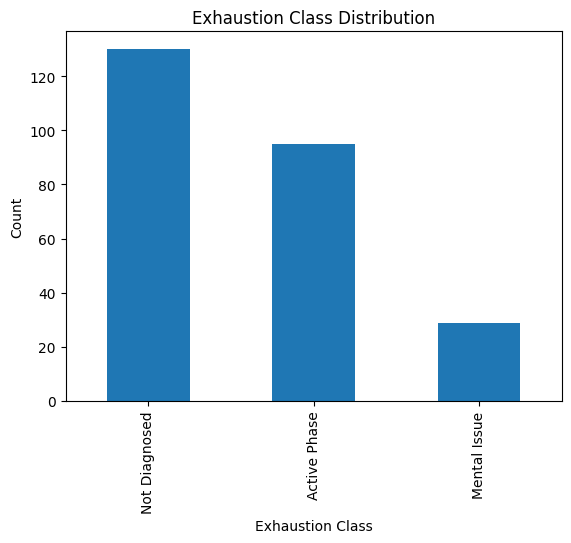

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot of the exhaustion_class column
df['exhaustion_class'].value_counts().plot(kind='bar')
plt.title('Exhaustion Class Distribution')
plt.xlabel('Exhaustion Class')
plt.ylabel('Count')
plt.show()

## Directory organization

In [ ]:
dataset_dir ="EEG_DATA"
output_dir = "dataset"
channel_mapping = {
            'EEG Fp1': 'Fp1',
            'EEG Fp2': 'Fp2',
            'EEG F3': 'F3',
            'EEG F4': 'F4',
            'EEG F7': 'F7',
            'EEG F8': 'F8',
            'EEG T3': 'T3',
            'EEG T4': 'T4',
            'EEG C3': 'C3',
            'EEG C4': 'C4',
            'EEG T5': 'T5',
            'EEG T6': 'T6',
            'EEG P3': 'P3',
            'EEG P4': 'P4',
            'EEG O1': 'O1',
            'EEG O2': 'O2',
            'EEG Fz': 'Fz',
            'EEG Cz': 'Cz',
            'EEG Pz': 'Pz'
        }
channel_types = {'EEG A2-A1': 'misc','ECG ECG': 'ecg'}

In [ ]:
import os
import mne
import numpy as np
import logging

# Set up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.CRITICAL)

# Define log formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

# Create file handler and set level and formatter
file_handler = logging.FileHandler('my_log_file.log')
file_handler.setLevel(logging.CRITICAL)
file_handler.setFormatter(formatter)

# Create stream handler and set level
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

# Add handlers to logger
logger.addHandler(file_handler)
logger.addHandler(stream_handler)

class EEGPreprocessor:
    """
    A class for preprocessing EEG data.

    Attributes:
        raw_file_path (str): Path to the raw EEG file.
        output_dir (str): Path to the output directory.
        montage_system (str): Montage system to be used.
        misc_channels (dict): List of miscellaneous channels to be removed.
        channel_mapping (dict): A dictionary mapping old channel names to new channel names.
                                The keys are the original channel names and the values are the new channel names.
        channel_types (dict): A dictionary containing the channel names as keys and the corresponding channel type as value.

    Methods:
        load_eeg(): Load the raw EEG data.
        save_processed_file(): Save the processed EEG data.
        set_montage(): Set the montage for the EEG data.
        set_channel_names(): Map the names of the channels in the raw dataset to new names.
        set_channel_types(): Define the types of each channel in the EEG data.
        get_raw(): Return the raw EEG data.
        get_preprocessed(): Return the preprocessed EEG data.
        fit(): Placeholder method for model fitting (not implemented).
    """

    def __init__(self, raw_file_path, output_dir, channel_types=None, channel_mapping=None,
                 montage_system='standard_1020'):
        """
        Initialize the EEGPreprocessor class.

        Parameters:
            raw_file_path (str): Path to the raw EEG file.
            output_dir (str): Path to the output directory.
            montage_system (str): Montage system to be used.
            misc_channels (list): List of miscellaneous channels to be removed.
        """
        self.raw_file_path = raw_file_path
        self.output_dir = output_dir
        self.montage_system = montage_system
        self.__raw = None
        self.__preprocessed_signal = None
        self.channel_mapping = channel_mapping
        self.channel_types = channel_types

    def load_eeg(self):
        """
        Load the raw EEG data.
        """
        logger.info(f"Loading raw EEG data from {self.raw_file_path}")
        self.__raw = mne.io.read_raw(self.raw_file_path, preload=True)

    def save_processed_file(self):
        """
        Save the preprocessed EEG data.
        """
        if self.__preprocessed_signal is None:
            raise ValueError("No preprocessed data to save. Please preprocess the data first.")

        logger.info(f"Saving processed EEG data to {self.output_dir}")
        filename = f"{os.path.basename(self.raw_file_path).split('.')[0]}.fif"
        file_path = os.path.join(self.output_dir, filename)
        self.__preprocessed_signal.save(file_path, overwrite=True)


    def set_channel_names(self):
        """
        Map the names of the channels in the raw dataset to new names.
        """
        logger.info('Mapping Channel Names')
        if not isinstance(self.channel_mapping, dict):
            raise ValueError('Channel mapping must be a dictionary')

        try:
            self.__preprocessed_signal=self.__raw.rename_channels(self.channel_mapping)
        except Exception as e:
            print(e)
            raise TypeError('Provided channel map does not match data')

    def set_montage(self):
        """
        Set the montage for the EEG data.
        """
        logger.info(f"Setting montage to {self.montage_system}")
        try:
            montage = mne.channels.make_standard_montage(self.montage_system)
            self.__preprocessed_signal.set_montage(montage)
        except Exception as e:
            print(e)
            raise ValueError("Invalid channels name for the system")

    def set_channel_types(self):
        """
        Define the types of each channel in the EEG data.
        """
        logger.info('Defining channel types')
        if not isinstance(self.channel_types, dict):
            raise ValueError('Channel mapping must be a dictionary')
        try:
            self.__preprocessed_signal.set_channel_types(self.channel_types, verbose=None)
        except Exception as e:
            print(e)
            raise ValueError('The provided type mapping does not match the data')

    def get_raw(self):
        """
        Returns the raw EEG data.
        """
        return self.__raw

    def get_preprocessed(self):
        """
        Returns the preprocessed EEG data.
        """
        return self.__preprocessed_signal

    def fit(self):
        """
        Preprocess EEG data and save the processed file.

        This method executes the preprocessing steps including loading EEG data, setting channel names,
        setting channel types, setting montage, and saving the processed file.

        Raises:
            ValueError: If there is no preprocessed data to save.
        """
        try:
            # Load raw EEG data
            self.load_eeg()

            # Set channel names
            if self.channel_mapping:
                self.set_channel_names()

            # Set channel types
            if self.channel_types:
                self.set_channel_types()

            # Set montage
            self.set_montage()

            # Save processed file
            self.save_processed_file()

            logger.info("Preprocessing completed successfully.")
        except Exception as e:
            logger.error(f"Error occurred during preprocessing: {str(e)}")
            raise



In [ ]:
a = mne.io.read_raw("EEG_DATA/azo.edf", preload=True)

Extracting EDF parameters from /Users/stepansusko/Programming/Azimuthal/EEG_DATA/azo.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 172111  =      0.000 ...   344.222 secs...


In [ ]:
import mne

In [ ]:
persons = [os.path.join(dataset_dir,f"{name}.edf") for name,_ in name_to_label.items()]
for person in persons:
    eeg_data = EEGPreprocessor(raw_file_path=person, output_dir=output_dir, channel_types=channel_types, channel_mapping=channel_mapping,
                 montage_system='standard_1020')
                 # Fit the data
    eeg_data.fit()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


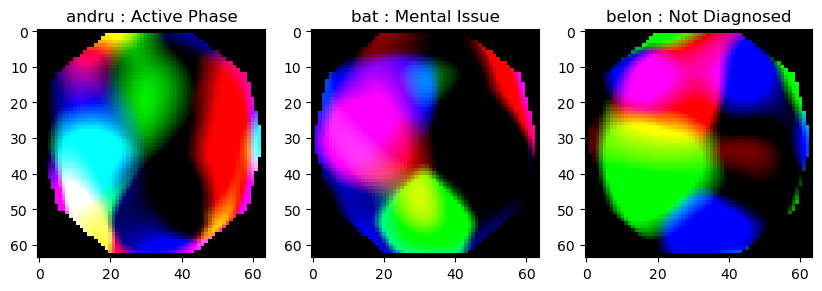

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first array
axs[0].imshow(person_1[0])
axs[0].set_title(f'{subject_1[0]} : {classes[0]}')

# Plot the second array
axs[1].imshow(person_2[0])
axs[1].set_title(f'{subject_2[1]} : {classes[1]}')

# Plot the third array
axs[2].imshow(person_3[0])
axs[2].set_title(f'{subject_3[2]} : {classes[2]}')

plt.show()